In [6]:
import numpy as np
import copy
import itertools
import random
import sys
import os
import pickle
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]

NUM_VERTICES = 7
OP_SPOTS = NUM_VERTICES - 2
MAX_EDGES = 9
# @classmethod
def random_cell():
    """ 
    From the NASBench repository 
    one-hot adjacency matrix
    draw [0,1] for each slot in the adjacency matrix
    """
    while True:
        matrix = np.random.choice(
            [0, 1], size=(NUM_VERTICES, NUM_VERTICES))
        matrix = np.triu(matrix, 1)
        ops = np.random.choice(OPS, size=NUM_VERTICES).tolist()
        ops[0] = INPUT
        ops[-1] = OUTPUT
        
        return {
            'matrix': matrix,
            'ops': ops
        }

In [10]:
m = random_cell()

In [8]:
ops = np.random.choice(OPS, size=NUM_VERTICES).tolist()
ops

['conv1x1-bn-relu',
 'conv3x3-bn-relu',
 'maxpool3x3',
 'conv1x1-bn-relu',
 'conv3x3-bn-relu',
 'maxpool3x3',
 'maxpool3x3']

In [9]:
ops[0] = INPUT
ops[-1] = OUTPUT
ops

['input',
 'conv3x3-bn-relu',
 'maxpool3x3',
 'conv1x1-bn-relu',
 'conv3x3-bn-relu',
 'maxpool3x3',
 'output']

In [11]:
def encode_standard():
    """ 
    compute the "standard" encoding,
    i.e. adjacency matrix + op list encoding 
    """
    encoding_length = (NUM_VERTICES ** 2 - NUM_VERTICES) // 2 + OP_SPOTS
    encoding = np.zeros((encoding_length))
    dic = {CONV1X1: 0., CONV3X3: 0.5, MAXPOOL3X3: 1.0}
    n = 0
    for i in range(NUM_VERTICES - 1):
        for j in range(i+1, NUM_VERTICES):
            encoding[n] = m["matrix"][i][j]
            n += 1
    for i in range(1, NUM_VERTICES - 1):
        encoding[-i] = dic[m["ops"][i]]
    return tuple(encoding)
encode_standard()

(0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.5,
 0.5,
 1.0,
 0.0,
 0.5)

In [12]:
def get_paths():
        """ 
        return all paths from input to output
        """
        paths = []
        for j in range(0, NUM_VERTICES):
            paths.append([[]]) if m["matrix"][0][j] else paths.append([])
        
        # create paths sequentially
        for i in range(1, NUM_VERTICES - 1):
            for j in range(1, NUM_VERTICES):
                if m["matrix"][i][j]:
                    for path in paths[i]:
                        paths[j].append([*path, m["ops"][i]])
        return paths[-1]

def get_path_indices():
    """
    compute the index of each path
    There are 3^0 + ... + 3^5 paths total.
    (Paths can be length 0 to 5, and for each path, for each node, there
    are three choices for the operation.)
    """
    paths = get_paths()
    mapping = {CONV3X3: 0, CONV1X1: 1, MAXPOOL3X3: 2}
    path_indices = []

    for path in paths:
        index = 0
        for i in range(NUM_VERTICES - 1):
            if i == len(path):
                path_indices.append(index)
                break
            else:
                index += len(OPS) ** i * (mapping[path[i]] + 1)

    path_indices.sort()
    return tuple(path_indices)

def encode_paths():
    """ output one-hot encoding of paths """
    num_paths = sum([len(OPS) ** i for i in range(OP_SPOTS + 1)])
    path_indices = get_path_indices()
    encoding = np.zeros(num_paths)
    for index in path_indices:
        encoding[index] = 1
    return encoding
encode_paths()

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [10]:
import torch 
path = "/home/qhy/Reserach/AICAS/log/741-stage-1_1_4_4_3-ratio-0.875_0.875_0.375_0.5_1.0-op-repvgg_vgg_vgg_vgg_repvgg-max-False_False_True_True_False-pool_type-None_None_maxpool_avgpool_None_None-cifar10/best_ckpt.pth"
param = torch.load(path)

In [1]:
# for k in param['model'].keys():
#     # if "pool" in k:
#     print(k)

In [2]:
# for name, module in m._modules.items():
#     print (name," : ",module)

In [3]:
# m.stage_2

In [6]:
import sys
sys.path.append("../models/")
from model import Net
from easydict import EasyDict
import yaml
config_path = "/home/qhy/Reserach/AICAS/config/742-stage-1_3_4_1_1-ratio-0.5_0.5_1.0_0.625_0.375-op-vgg_repvgg_vgg_vgg_repvgg-pool-False_True_False_True_True_True-pool_type-None_maxpool_None_maxpool_avgpool_avgpool-cifar10.yaml"
config = EasyDict(yaml.full_load(open(config_path)))
m = Net(config,10)

# m

In [26]:
model_named_parameters = [x for x in m.named_parameters()]

In [29]:
for name, layer in m.named_modules():
    if 'pool' in name:
        print(name)


stage_3.avgpool
pool


In [24]:
config = EasyDict(yaml.full_load(open("/home/qhy/Reserach/AICAS/config/771-stage-2_4_6_1_1-ratio-0.25_0.25_0.125_1.0_0.125-op-vgg_repvgg_repvgg_vgg_vgg-pool-False_True_False_True_False_True-pool_type-None_maxpool_None_maxpool_None_avgpool-cifar10.yaml")))
config['model']['op_type']

['vgg', 'repvgg', 'repvgg', 'vgg', 'vgg']

In [ ]:
encode(771,config)

In [13]:
config['model']['pool_type']

[None, None, 'avgpool', None, None, 'maxpool']

In [16]:
mapping_pool = {"maxpool":0,"avgpool":1,None:2}
[mapping_pool[i] for i in config['model']['pool_type']]

[2, 2, 1, 2, 2, 0]

In [9]:
mapping_pool = {True:0,False:2}
[mapping_pool[i] for i in config['model']['with_maxpool']]

[2, 0, 0, 2, 2]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
import os
from easydict import EasyDict
import yaml
# acc = np.zeros(740)
data = {}

def encode(num,config):
    mapping_op = {'repvgg':0,'vgg':1}
    mapping_pool = {'maxpool':0,'avgpool':1,"None":2}
    code = []
    if config['model']["stage_ratio"] != None:
        code += config['model']["stage_ratio"]
    else:
        print("Error in stage ration")
    
    if config['model']['op_type'] != None:
        code += [mapping_op[i] for i in config['model']['op_type']]
    else:
        print("Error in op type")
    
    if 509<num<642:
        mapping_pool = {True:0,False:2}
        if config['model']['with_maxpool'] != None:
            code += [mapping_pool[i] for i in config['model']['with_maxpool']]
            code += [0]
        else:
            print("Error in maxpool")
    elif 641<num<650:
        mapping_pool = {True:1,False:2}
        if config['model']['with_maxpool'] != None:
            code += [mapping_pool[i] for i in config['model']['with_maxpool']]
            code += [1]
        else:
            print("Error in maxpool")
    elif 649<num:
        mapping_pool = {"maxpool":0,"avgpool":1,None:2}
        if config['model']['pool_type'] != None:
            code += [mapping_pool[i] for i in config['model']['pool_type']]
        else:
            print("Error in maxpool")
    if config['model']['stage_layer'] != None:
        code += config['model']['stage_layer']
    else:
        print("Error in stage layer")
    assert len(code) == 21,print(len(code))
    return code
    
model_list = os.listdir("../config/")
for model_path in tqdm.tqdm(model_list):
    # print(model_path)
    config_path = os.path.join("../config/",model_path)
    model_path_2 = os.path.join("/home/qhy/Reserach/AICAS/log",model_path.replace(".yaml",""),"best_ckpt.pth")
    
    if model_path not in ["repvgg.yaml","vgg.yaml","vgg16-stage-2_2_3_3_3-ratio-1.0_1.0_1.0_1.0_1.0-op-vgg_vgg_vgg_vgg_vgg-max-False_True_True_True_True.yaml",
                          "stage-1_3_4_1-ratio-1.0_0.375_0.75_0.125-op-vgg_vgg_repvgg_vgg-max-True_False_True_False.yaml",
                          "repvgg-A0-stage-2_2_3_3_3-ratio-1.0_1.0_1.0_1.0_1.0-op-repvgg_repvgg_repvgg_repvgg_repvgg-max-False_False_False_False_False.yaml",
                          "benchmark-vgg11-stage-1_1_2_2_2-ratio-1.0_1.0_1.0_1.0_1.0-op-vgg_vgg_vgg_vgg_vgg-max-False_True_True_True_True-cifar10.yaml",
                          "benchmark-vgg13-stage-2_2_2_2_2-ratio-1.0_1.0_1.0_1.0_1.0-op-vgg_vgg_vgg_vgg_vgg-max-False_True_True_True_True-cifar10.yaml",
                          "benchmark-vgg16-stage-2_2_3_3_3-ratio-1.0_1.0_1.0_1.0_1.0-op-vgg_vgg_vgg_vgg_vgg-max-False_True_True_True_True-cifar10.yaml",
                          "benchmark-vgg19-stage-2_2_4_4_4-ratio-1.0_1.0_1.0_1.0_1.0-op-vgg_vgg_vgg_vgg_vgg-max-False_True_True_True_True-cifar10.yaml",
                          "benchmark-repvgg-a0-stage-1_2_4_14_1-ratio-0.75_0.75_0.75_0.75_2.5-op-repvgg_repvgg_repvgg_repvgg_repvgg-max-False_False_False_False_False-cifar10.yaml",
                          "benchmark-repvgg-a1-stage-1_2_4_14_1-ratio-1.0_1.0_1.0_1.0_2.5-op-repvgg_repvgg_repvgg_repvgg_repvgg-max-False_False_False_False_False-cifar10.yaml",
                          "benchmark-repvgg-a2-stage-1_2_4_14_1-ratio-1.5_1.5_1.5_1.5_2.75-op-repvgg_repvgg_repvgg_repvgg_repvgg-max-False_False_False_False_False-cifar10.yaml",
                          "benchmark-repvgg-b0-stage-1_2_4_14_1-ratio-1.0_1.0_1.0_1.0_2.75-op-repvgg_repvgg_repvgg_repvgg_repvgg-max-False_False_False_False_False-cifar10.yaml",
                          "benchmark-repvgg-b1-stage-1_2_4_14_1-ratio-2.0_2.0_2.0_2.0_4.0-op-repvgg_repvgg_repvgg_repvgg_repvgg-max-False_False_False_False_False-cifar10.yaml",
                          "benchmark-repvgg-b2-stage-1_2_4_14_1-ratio-2.5_2.5_2.5_2.5_5.0-op-repvgg_repvgg_repvgg_repvgg_repvgg-max-False_False_False_False_False-cifar10.yaml",
                          "benchmark-repvgg-b3-stage-1_2_4_14_1-ratio-3.0_3.0_3.0_3.0_5.0-op-repvgg_repvgg_repvgg_repvgg_repvgg-max-False_False_False_False_False-cifar10.yaml",
                          "benchmark-repvgg-a0-stage-1_2_4_14_1-ratio-0.75_0.75_0.75_0.75_2.5-op-repvgg_repvgg_repvgg_repvgg_repvgg-max-False_False_False_False_False-cifar10-lr.yaml",
                          "benchmark-repvgg-a1-stage-1_2_4_14_1-ratio-1.0_1.0_1.0_1.0_2.5-op-repvgg_repvgg_repvgg_repvgg_repvgg-max-False_False_False_False_False-cifar10-lr.yaml"]:
        num = int(model_path.split("-")[0])
        # print(num)
        if os.path.exists(model_path_2) and (510<=num<740):
            param = torch.load(model_path_2)
            acc = param['max_accuracy']
            if(acc>0.1):
                config = EasyDict(yaml.full_load(open(config_path)))
                code = encode(config=config,num=num)
                data[num] = {"code":code,"acc":acc}
                print(num,"done")
                
                
                


In [27]:
data.keys()

dict_keys([685, 546, 623, 556, 548, 735, 526, 678, 669, 707, 560, 725, 593, 538, 648, 696, 739, 715, 511, 611, 733, 723, 583, 717, 662, 697, 600, 720, 599, 515, 550, 568, 577, 691, 566, 597, 518, 549, 664, 643, 540, 595, 636, 533, 690, 692, 713, 584, 654, 585, 523, 721, 729, 663, 730, 640, 675, 716, 661, 606, 711, 513, 700, 645, 681, 576, 668, 620, 714, 521, 608, 512, 728, 613, 734, 615, 536, 544, 659, 624, 570, 558, 524, 680, 580, 737, 652, 684, 639, 567, 672, 671, 699, 609, 547, 701, 619, 516, 622, 738, 545, 579, 704, 586, 687, 726, 634, 614, 592, 575, 588, 522, 591, 646, 541, 727, 656, 529, 520, 535, 706, 641, 708, 674, 517, 612, 627, 676, 732, 688, 589, 571, 532, 630, 705, 625, 694, 695, 651, 596, 626, 590, 653, 736, 633, 698, 647, 525, 686, 542, 510, 574, 677, 722, 710, 712, 702, 572, 594, 530, 519, 683, 527, 618, 658, 660, 673, 607, 632, 531, 682, 537, 629, 534, 718, 665, 573, 670, 657, 514, 693, 628, 557, 581, 719, 578, 631, 731, 637, 644, 617, 621, 587, 528, 667, 569, 709, 703,

In [43]:
code_dataset = []
acc_dataset = []
for k in data.keys():
    code_dataset.append(data[k]['code'])
    acc_dataset.append(data[k]['acc'])

In [31]:
import numpy as np
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# NOTE: faster on CPU
device = torch.device("cpu")
def accuracy_mse(prediction, target, scale=100.0):
    prediction = prediction.detach() * scale
    target = (target) * scale
    return F.mse_loss(prediction, target)
# def predictor_MLP()
class FeedforwardNet(nn.Module):
    def __init__(
        self,
        input_dims: int = 5,
        num_layers: int = 3,
        layer_width: list = [10, 10, 10],
        output_dims: int = 1,
        activation="relu",
    ):
        super(FeedforwardNet, self).__init__()
        assert (
            len(layer_width) == num_layers
        ), "number of widths should be \
        equal to the number of layers"

        self.activation = eval("F." + activation)

        all_units = [input_dims] + layer_width
        self.layers = nn.ModuleList(
            [nn.Linear(all_units[i], all_units[i + 1]) for i in range(num_layers)]
        )

        self.out = nn.Linear(all_units[-1], 1)

        # make the init similar to the tf.keras version
        for l in self.layers:
            torch.nn.init.xavier_uniform_(l.weight)
            torch.nn.init.zeros_(l.bias)
        torch.nn.init.xavier_uniform_(self.out.weight)
        torch.nn.init.zeros_(self.out.bias)

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        return self.out(x)

    def basis_funcs(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        return 

In [32]:
predictor = FeedforwardNet(21,3,[30,40,50],1,'relu')

In [41]:
input = torch.tensor(data[550]["code"])
input.shape

torch.Size([21])

In [42]:
predictor(input)

tensor([0.1602], grad_fn=<AddBackward0>)

In [55]:
from timm.utils import accuracy, AverageMeter
import tqdm

def query(model,xtest, info=None, eval_batch_size=None):
   
    X_tensor = torch.FloatTensor(xtest).to(device)
    test_data = TensorDataset(X_tensor)

    eval_batch_size = len(xtest) if eval_batch_size is None else eval_batch_size
    test_data_loader = DataLoader(
        test_data, batch_size=eval_batch_size, pin_memory=False
    )

    model.eval()
    pred = []
    with torch.no_grad():
        for _, batch in enumerate(test_data_loader):
            prediction = model(batch[0].to(device)).view(-1)
            pred.append(prediction.cpu().numpy())

    pred = np.concatenate(pred)
    return np.squeeze(pred)
def fit(hyperparams,xtrain,ytrain,epochs=500,loss='mae',verbose=0):
    num_layers = hyperparams["num_layers"]
    layer_width = hyperparams["layer_width"]
    batch_size = hyperparams["batch_size"]
    lr = hyperparams["lr"]
    regularization = hyperparams["regularization"]
    
    mean = np.mean(ytrain)
    std = np.std(ytrain)
    
    X_tensor = torch.FloatTensor(xtrain).to(device)
    Y_tensor = torch.FloatTensor(ytrain).to(device)
    train_data = TensorDataset(X_tensor,Y_tensor)
    data_loader = DataLoader(
        train_data,
        batch_size = batch_size,
        shuffle= True,
        drop_last=False,
        pin_memory=False,
    )
    model = FeedforwardNet(hyperparams["input_dims"],hyperparams["num_layers"],hyperparams["layer_width"],1,'relu')
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))
    
    if loss == "mse":
        criterion = nn.MSELoss().to(device)
    elif loss == "mae":
        criterion = nn.L1Loss().to(device)
    model.train()
    
    for e in tqdm.trange(epochs):
        meters_loss = AverageMeter()
        meters_mse = AverageMeter()
        
        for b, batch in enumerate(data_loader):
            optimizer.zero_grad()
            input = batch[0].to(device)
            target = batch[1].to(device)
            prediction = model(input).view(-1)

            loss_fn = criterion(prediction, target)
            # add L1 regularization
            params = torch.cat(
                [
                    x[1].view(-1)
                    for x in model.named_parameters()
                    if x[0] == "out.weight"
                ]
            )
            loss_fn += regularization * torch.norm(params, 1)
            loss_fn.backward()
            optimizer.step()

            mse = accuracy_mse(prediction, target)
            meters_loss.update(
                loss_fn.item(), n=target.size(0)
            )
            
            meters_mse.update(
                 mse.item(), n=target.size(0)
            )

        if verbose and e % 100 == 0:
            print("Epoch {}, {}, {}".format(e, meters_loss["loss"], meters_mse["mse"]))

    train_pred = np.squeeze(query(model,xtrain))
    train_error = np.mean(abs(train_pred - ytrain))
    return train_error,model



In [122]:
train_num = 115
train_code_dataset = code_dataset[0:train_num]
test_code_dataset = code_dataset[train_num:]
train_acc_dataset = acc_dataset[0:train_num]
test_acc_dataset = acc_dataset[train_num:]
hyperparams = {
    "input_dims" : 21,
    "num_layers" : 3,
    "layer_width" : [30, 20, 10],
    "batch_size" : 100,
    "lr" : 0.1,
    "regularization":0.2
}
train_error,model_trained = fit(hyperparams,train_code_dataset,train_acc_dataset,epochs=500,loss='mae',verbose=0)
print(train_error)

100%|██████████| 500/500 [00:01<00:00, 355.65it/s]

1.0523372537364133


In [83]:
train_error 

1.8624087046747608

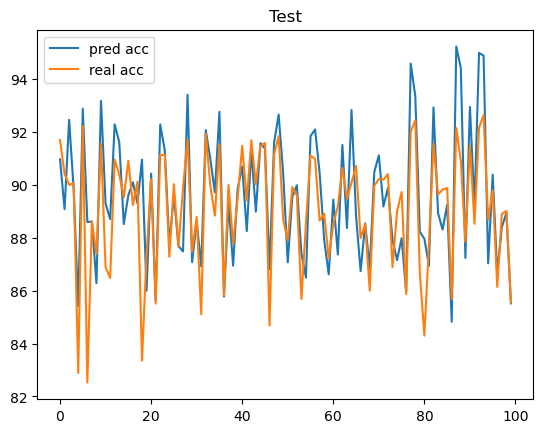

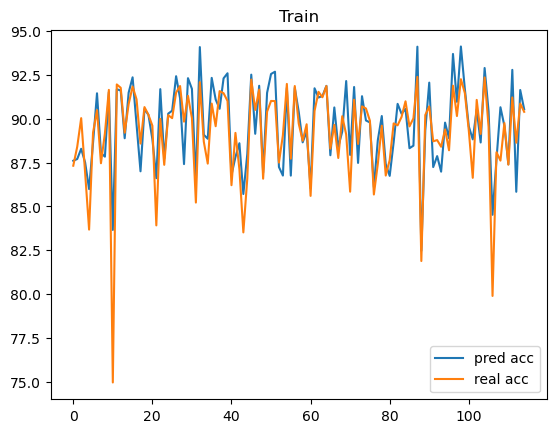

====TRAIN====
std 3.486941598018281
mean 0.3910707822053334
MSE 2.2293251974540924
RMSE 1.493092494607783
MAE 1.0523373200789745
MAPE 0.012032815967922909
====TEST====
std 3.5735274233045677
mean 0.34946020375127423
MSE 2.793301589969841
RMSE 1.6713173217464843
MAE 1.2217301696777343
MAPE 0.013817715025019965


In [123]:
import matplotlib.pyplot as plt
from sklearn import metrics

test_pred = []
# for k in data.keys():
for i in test_code_dataset:
    input = torch.tensor(i)
    test_pred.append(model_trained(input).detach().numpy())
plt.plot(range(len(test_pred)),test_pred,label="pred acc")
plt.plot(range(len(test_pred)),test_acc_dataset,label="real acc")
plt.legend()
plt.title("Test")
plt.show()

train_pred = []
for i in train_code_dataset:
    input = torch.tensor(i)
    train_pred.append(model_trained(input).detach().numpy())
plt.plot(range(len(train_pred)),train_pred,label="pred acc")
plt.plot(range(len(train_pred)),train_acc_dataset,label="real acc")
plt.legend()
plt.title("Train")
plt.show()
print("====TRAIN====")
MSE = metrics.mean_squared_error(np.array(train_acc_dataset), np.array(train_pred))
RMSE = metrics.mean_squared_error(np.array(train_acc_dataset), np.array(train_pred))**0.5
MAE = metrics.mean_absolute_error(np.array(train_acc_dataset), np.array(train_pred))
MAPE = metrics.mean_absolute_percentage_error(np.array(train_acc_dataset), np.array(train_pred))
print("std",np.std(np.array(train_pred)-np.array(train_acc_dataset)))
print("mean",np.mean(np.array(train_pred)-np.array(train_acc_dataset)))
print("MSE", MSE)
print("RMSE", RMSE)
print("MAE",MAE)
print("MAPE",MAPE)
print("====TEST====")
MSE = metrics.mean_squared_error(np.array(test_acc_dataset), np.array(test_pred))
RMSE = metrics.mean_squared_error(np.array(test_acc_dataset), np.array(test_pred))**0.5
MAE = metrics.mean_absolute_error(np.array(test_acc_dataset), np.array(test_pred))
MAPE = metrics.mean_absolute_percentage_error(np.array(test_acc_dataset), np.array(test_pred))
print("std",np.std(np.array(test_pred)-np.array(train_acc_dataset)))
print("mean",np.mean(np.array(test_pred)-np.array(train_acc_dataset)))
print("MSE", MSE)
print("RMSE", RMSE)
print("MAE",MAE)
print("MAPE",MAPE)